In [1]:
import tensorflow as tf
import numpy as np
from time import time
from utils import plot_images, read_mnist_data
from tfops import fc, inflate, flatten, conv, deconv
from os.path import exists

In [2]:
data, _ = read_mnist_data()

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Data shapes:
Training - x: (55000, 784), y:(55000, 10)
Test - x: (10000, 784), y:(10000, 10)
Validation - x: (5000, 784), y:(5000, 10)


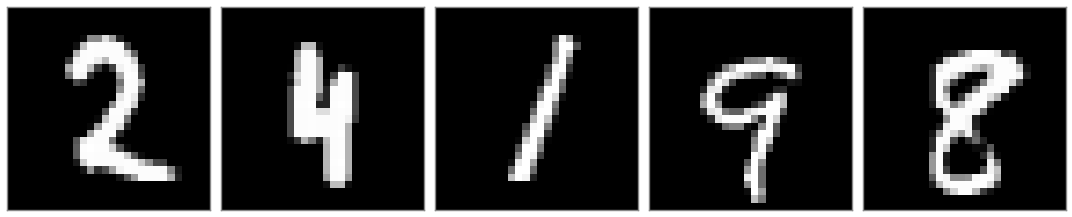

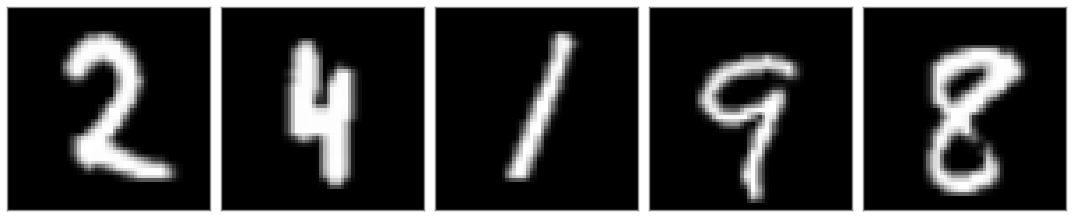

In [48]:
plot_images(data.train.images[:5])
sess = tf.Session()
with sess.as_default():
    plot_images(tf.image.resize_bilinear(data.train.images[:5].reshape(-1, 28, 28, 1), (58, 58)).eval().reshape(5, -1))
sess.close()

In [49]:
def generator(z):
    x_gen = fc(z, 64 * 7 * 7, 'relu', 'fc1')
    x_gen = inflate(x_gen, (7, 7))
    x_gen = tf.image.resize_bilinear(x_gen, (14, 14), name='resize1')
    x_gen = tf.layers.batch_normalization(conv(x_gen, 32, reduce_size=False, name='conv1'))
    x_gen = tf.image.resize_bilinear(x_gen, (28, 28), name='resize2')
    return conv(x_gen, 1, activation='tanh', reduce_size=False, name='conv2')

In [38]:
def discriminator(img):
    p = tf.layers.batch_normalization(conv(img, 64, 'lrelu', name='conv1'), name='bn1')
    p = tf.layers.batch_normalization(conv(p, 128, 'lrelu', name='conv2'), name='bn2')
    p = flatten(p, 'flatten')
    return fc(p, 1, 'sigmoid', 'fc2')

In [39]:
def log(_in, name=None):
    return tf.log(tf.maximum(1e-5, _in), name)

In [50]:
z_dim = 128

tf.reset_default_graph()

with tf.name_scope('inputs'):
    x = tf.placeholder(tf.float32, (None, 784), 'x')
    z = tf.placeholder(tf.float32, (None, z_dim), 'z')
    
with tf.variable_scope('generator'):
    x_gen = generator(z) 
    
with tf.variable_scope('discriminator'):
    p_x = discriminator(tf.reshape(x, (-1, 28, 28, 1)))
    tf.get_variable_scope().reuse_variables()
    p_g = discriminator(x_gen)
    
    
with tf.name_scope('optimizer'):
    loss_g = -tf.reduce_mean(log(p_g))
    loss_d = -tf.reduce_mean(log(p_x)) - tf.reduce_mean(log(1 - p_g))
    optimizer_g = tf.train.AdamOptimizer(1e-5).minimize(loss_g, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator'))
    optimizer_d = tf.train.AdamOptimizer(1e-5).minimize(loss_d, var_list=tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator'))

tf.summary.scalar('loss_g', loss_g)
tf.summary.scalar('loss_d', loss_d)
summ = tf.summary.merge_all()

In [41]:
def plot_generated_images(sess):
    generated_images = sess.run(x_gen, feed_dict={z: np.random.randn(11, z_dim)})
    plot_images(generated_images.reshape((-1, 784)) + 0.5)

In [42]:
batch_size = 256
batches_per_epoch = int(data.train.num_examples / batch_size)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

def optimize(epochs=1):
    start_time = time()
    
    writer = tf.summary.FileWriter('output/DCGAN-Resize', tf.get_default_graph())
    saver = tf.train.Saver()
    
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                x_batch, _ = data.train.next_batch(batch_size)
                z_batch = np.random.randn(batch_size, z_dim)
                for _ in range(2):
                    sess.run(optimizer_g, feed_dict={x: x_batch - 0.5, z: z_batch})

                sess.run(optimizer_d, feed_dict={x: x_batch - 0.5, z: z_batch})

                if batch % 1000 == 0:
                    writer.add_summary(sess.run(summ, feed_dict={x: x_batch - 0.5, z: z_batch}), global_step=epoch * batches_per_epoch + batch)
            
            print("{} / {} ({}%)".format(epoch + 1, epochs, np.round((epoch + 1) / epochs * 100, 2)))
            plot_generated_images(sess)
            
        saver.save(sess, 'checkpoints/DCGAN-Resize/DCGAN-Resize', write_meta_graph=False)
        
    print("Time taken - {}s".format(np.round(time() - start_time, 2)))

INFO:tensorflow:Restoring parameters from checkpoints/DCGAN-Resize/DCGAN-Resize


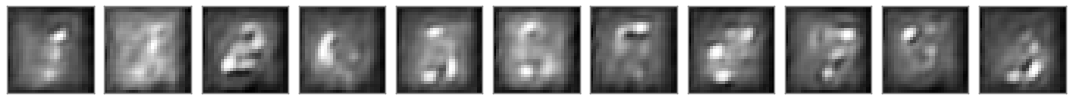

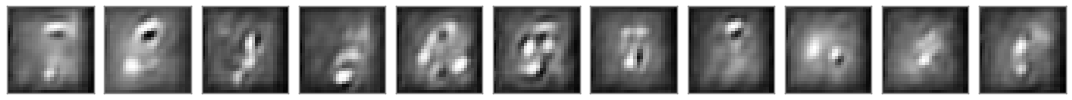

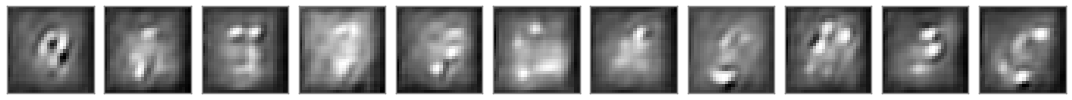

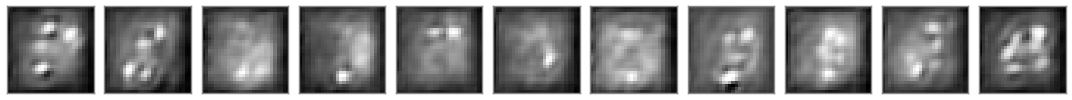

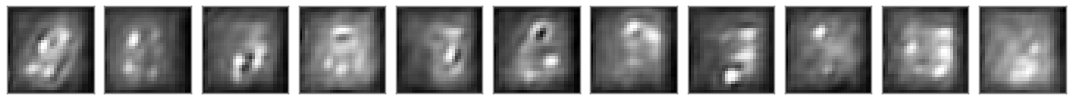

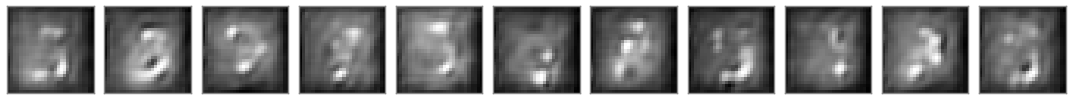

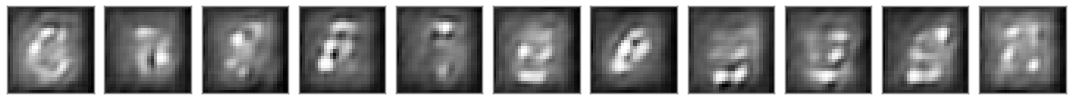

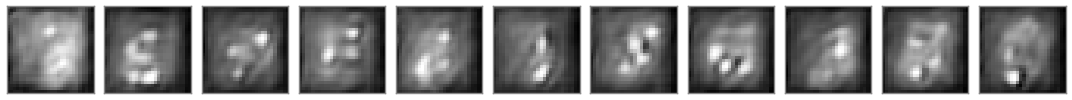

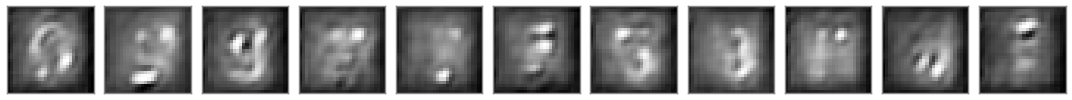

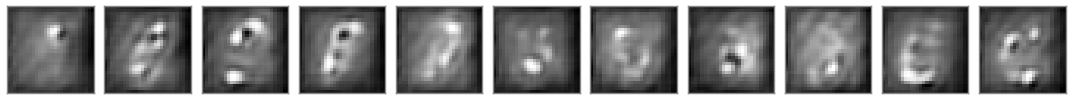

In [52]:
if exists('checkpoints/DCGAN-Resize/DCGAN-Resize.data-00000-of-00001'):
    with tf.Session(config=config) as sess:
        saver = tf.train.Saver()
        saver.restore(sess, 'checkpoints/DCGAN-Resize/DCGAN-Resize')
        
        for _ in range(10):
            plot_generated_images(sess)
else:
    optimize(30)